In [3]:
require 'torch'
require 'nn'
require 'image'
utils = require 'utils'
require 'nngraph'

In [12]:
local cmd = torch.CmdLine()

-- Model options
cmd:option('-model', 'checkpoint.t7')

-- Input / output options
cmd:option('-input_image', 'ei_capitan.jpeg')
cmd:option('-output_image', 'out.png')
cmd:option('-input_dir', '')
cmd:option('-output_dir', '')

-- GPU options
cmd:option('-gpu', -1)
cmd:option('-backend', 'cuda')
cmd:option('-use_cudnn', 1)
cmd:option('-cudnn_benchmark', 0)

opt = cmd:parse(arg or {})

In [13]:
dtype, use_cudnn = utils.setup_gpu(opt.gpu, opt.backend, opt.use_cudnn == 1)
ok, checkpoint = pcall(function() return torch.load(opt.model) end)
dtype = 'torch.FloatTensor'
if not ok then
    print('ERROR: Could not load model from ' .. opt.model)
    print('You may need to download the pretrained models by running')
    print('bash download_colorization_model.sh')
end

In [14]:
model = checkpoint.model
model:evaluate()
model:type(dtype)

In [15]:
img = image.load(opt.input_image)
origin_img = image.scale( img, torch.round(img:size(3)/8)*8, torch.round(img:size(2)/8)*8 )
H, W = origin_img:size(2), origin_img:size(3)

scaled_img = image.scale(origin_img, 224, 224)

origin_img_pre = origin_img
scaled_img_pre = scaled_img

if img:size(1)>1 then
    origin_img_y = image.rgb2y(origin_img_pre)
    scaled_img_y = image.rgb2y(scaled_img)
end

origin_img_pre = origin_img_y:view(1, 1, H, W):type(dtype)
origin_img_pre = origin_img_pre:add(-0.5):type(dtype)

scaled_img_pre = scaled_img_y:view(1, 1, 224, 224):type(dtype)
scaled_img_pre = scaled_img_pre:div(255):type(dtype)

In [16]:
input = {origin_img_pre, scaled_img_pre}
model.forwardnodes[12].data.module.modules[3].nfeatures = H /8
model.forwardnodes[12].data.module.modules[4].nfeatures = W /8

In [17]:
uv = model:forward(input)

In [18]:
uv = uv:type('torch.DoubleTensor'):view(2,uv:size(3),uv:size(4))
img_pre = image.rgb2yuv(origin_img)[1]:view(1, H, W ):type('torch.DoubleTensor')
uv = image.scale(uv, W ,H)

In [19]:
new_u = uv[1]:view(1, H, W ):type('torch.DoubleTensor'):mul(0.436)
new_v = uv[2]:view(1, H, W ):type('torch.DoubleTensor'):mul(0.615)
new_uv = torch.cat(new_u, new_v, 1)

In [20]:
img_out = torch.cat(img_pre, new_uv, 1)
final_out = image.yuv2rgb(img_out)

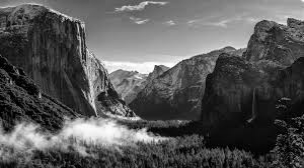

In [21]:
itorch.image(img_pre)

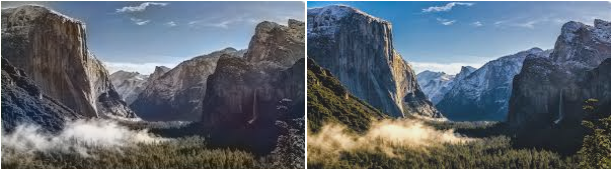

In [22]:
itorch.image({final_out, origin_img})

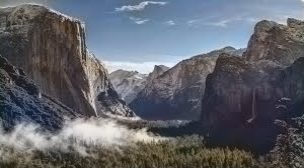

In [23]:
itorch.image(final_out)